<a href="https://colab.research.google.com/github/damithdev/twitter-news-scraping/blob/master/Twitter_Scraping_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Text Analytics Coursework - MSc in Big Data Analytics
#### July 2020

###### Name: Damith Warnakulasuriya
###### IIT ID: 20191273
###### RGU ID: 1915109


(Implemented with Google colab environment)

### Answer (a)

Initializing necessary configurations

In [1]:
!pip install twitter # Installig Twitter


     |████████████████████████████████| 61kB 1.8MB/s 


###Constants

In [8]:
CONSUMER_KEY = ''
CONSUMER_SECRET = ''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''

bbc_screen_name = "BBCWorld"
cnn_screen_name = "CNN"

screen_names = [cnn_screen_name,bbc_screen_name]
min_pull_count = 2500;
item_pull_count = round(min_pull_count/len(screen_names))



Mounting Google Drive

Initializing Twitter API

In [13]:
import twitter # Twitter lib


auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth) # Initialize twitter api

type(twitter_api)

twitter.api.Twitter

Necessary Imports

In [14]:
import traceback
from urllib.parse import urlparse # parse urls into 6 components
from bs4 import BeautifulSoup # for pulling data out of HTML and XML files
import re
import requests
import time
import csv
import pandas as pd 

**function get_end_url**

*get expanded url from the tweet object*
*if the url is a tweet url get the tweet html and parse the website url*

returns re-directed webpage url

In [15]:


def get_end_url(item):
  # print(item)
  try:
    url = item['entities']['urls'][0]['expanded_url']
    r = requests.get(url)
    # print(r.url)
    parsed_uri = urlparse(r.url)
    result = '{uri.netloc}'.format(uri=parsed_uri)
    # print(result)
    if 'twitter' in result:
      id_of_tweet = item['id']
      time.sleep(4)
      html = twitter_api.statuses.oembed(_id=id_of_tweet)['html']
      # print(html)
      soup = BeautifulSoup(html)
      url = soup.p.a['href']
      r = requests.get(url)

    url = r.url

    # print(str(itr) +":"+ url)

    parsed_uri = urlparse(r.url)
    result = '{uri.netloc}'.format(uri=parsed_uri)
    if 'twitter' in result:
      return None;
    return url
  
  except Exception as e:
    print("exception")
    print(e)
    traceback.print_exc()
    return None    


builds the urls list until it reaches the minimum url count

fetch twitter user timeline continuously backwards,
extract url then find the end url using above method

then backup the urls to google drive for future use

In [ ]:


tweets = []
end_urls = []
newslist = {}

itr = 0

for item in screen_names:
  print(item)
  
  retries = 0;
  item_tweets = []
  max_id = None
  item_urls = []

  while len(item_urls) < item_pull_count:
    if retries > 30 : break;

    if max_id is not None:
      res = twitter_api.statuses.user_timeline(screen_name=item,count=item_pull_count,max_id=max_id)
    else :
      res = twitter_api.statuses.user_timeline(screen_name=item,count=item_pull_count)
    item_tweets += res
    last = res[len(res)-1]
    max_id = last['id']
    print(len(item_tweets))
    retries =+ 1

    for tweet in res:
      # if itr > 5 :
      #   retries = 11;
      #   itr = 0
      #   break;

      urls = tweet['entities']['urls']
      if urls == [] : continue
      url = urls[0]['expanded_url']
      newslist[url] = tweet
      resurl = get_end_url(tweet)
      if resurl is not None : 
        item_urls.append(resurl)
        itr += 1
        # print(str(itr)+" - " + resurl)

  tweets += item_tweets
  end_urls += item_urls

print("TOTAL TWEETS:" + str(len(tweets)))
print("TOTAL URLS:" + str(len(end_urls)))


#Save to csv using panas for reference
tempdf = pd.DataFrame(end_urls)
csv_data = tempdf.to_csv('news_urls.csv',index=False)

print("COMPLETE")

Prints list of end urls found

**Fetch URLs Backup file form github gist**

In [17]:
news_urls = 'https://github.com/damithdev/public_files/blob/master/news_urls.csv?raw=true'

news_urls_df = pd.read_csv(news_urls)



**Fetch Article Data from the URL list**

Extract the article body from the html.
Store extracted data in article_data.csv.
Backup article_data.csv to google drive for future use

In [21]:
print("Before fetching urls - "+ str(len(news_urls_df)))

articles = {}
errors = 0

itr = 0
for index, row in news_urls_df.iterrows():
  url = row['0']
  itr += 1
  
  try:
    r = requests.get(url)
    # print(r.url)
    page = r.text
    soup = BeautifulSoup(page)
    title = soup.title 
    # print(title)
    if title is not None:
      title = title.string
      content = ""
      flag = ""

      parsed_uri = urlparse(r.url)
      screen = '{uri.netloc}'.format(uri=parsed_uri)
      # print(screen)
      if 'cnn' in screen:
          header = soup.find("h1", {"class": "pg-headline"})
          content = header.find_parent("div", {"class": "l-container"})
          flag = "CNN"
      elif 'bbc' in screen:
          flag = "BBC"
          content = soup.find(property="articleBody")
      else:
        raise Exception("Cannot Determine News Type")
      
      # print(flag)
      title = title.string.split('- CNN')[0]
      # print(title)
      if content is not None:articles[title]={'Title':title,'Content':content}
      # print(str(len(articles)) + ":"+ title)
      # print('=============================================================')
  except Exception as e:
    errors += 1
    # print("exception")
    # print(e)
    # traceback.print_exc()

print("after fetching urls, articles based on unique titles (duplicate removal based on title) - "+ str(len(articles)))



csv_columns = ['Title','Content']
dict_data = []

for post in articles.values():
  dict_data.append(post)

# print(dict_data)

csv_file = "article_data.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow(data)
    
    print("Success")
    !cp article_data.csv "/content/gdrive/My Drive/colab_data"
except IOError:
    errors += 1
    print("I/O error")

print("Errors: " + str(articles))
print("Successful: "+ str(len(dict_data)))

Before fetching urls - 2678
after fetching urls, articles based on unique titles (duplicate removal based on title) - 1724
Success
cp: cannot create regular file '/content/gdrive/My Drive/colab_data': No such file or directory


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Prints the total number of urls before fetching

Prints the url and the extracted article's title

Prints the total number of articles after fetching and duplicate removal using article title

Displays number of failed attempts and successful attempts

### Answer (b)

Any pre-text explaining the code below...

**Fetch Article data csv from github (backed up)**

Reading csv into pandas dataframe

In [22]:
import pandas as pd 

news_data_url = 'https://github.com/damithdev/public_files/blob/master/article_data.csv?raw=true'

df = pd.read_csv(news_data_url)

**Cleaning Data**

In [23]:

import re
import string
import collections
from bs4 import BeautifulSoup


from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

def visible(element):
    if element.parent.name in ['style', 'script', '[document]', 'head', 'title', 'meta', 'Start', 'Post','Image']:
        return False
    elif re.match('<!--.*-->', str(element.encode('utf-8'))):
        return False
    return True

def removeOneTag(text, tag):
    return text[:text.find("<"+tag+">")] + text[text.find("</"+tag+">") + len(tag)+3:]

def removeBracketElement(text, tag):
    return text[:text.find("["+tag)] + text[text.find(tag+"]") + len(tag)+3:]

def apply_filter(dfcell):
  soup = BeautifulSoup(str(dfcell))
  data = soup.findAll(text=True)
  filtered = filter(visible, data)
  result =  ''.join(filtered)
  result = re.sub(r'[\t\r\n]', ' ', result)
  result = re.sub('Image copyright', ' ', result)
  result = re.sub('Getty Images', ' ', result)
  result = re.sub('Image caption', ' ', result)
  result = re.sub(r'\[if.+if\]', ' ', result)
  result = re.sub(r'Updated.+Messenger', ' ', result)
  result = re.sub(r' +', ' ', result)

  # print(result.strip())
  return result

def remove_characters_before_tokenization(sentence,
                                          keep_apostrophes=False):
    sentence = sentence.strip()
    if keep_apostrophes:
        PATTERN = r'[?|$|&|*|%|@|(|)|~]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    else:
        PATTERN = r'[^a-zA-Z0-9 ]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    return filtered_sentence

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = list(filter(None, [pattern.sub('', token) for token in tokens]))
    return filtered_tokens

**Tokenize**

In [24]:
import nltk
nltk.download('punkt')

def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences] 
    return word_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**convert to lower case**

In [25]:
def tolower(corpus):
  return corpus.lower()


Expand word contractions of the data using a contraction map

In [26]:
import requests

url = 'https://github.com/damithdev/public_files/blob/master/contractions.py?raw=true'
r = requests.get(url)

with open('contractions.py', 'wb') as f:
    f.write(r.content)

from contractions import CONTRACTION_MAP
def expand_contractions(sentence, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence

Apply filters to the dataframe to clean the data

In [27]:
df['filtered'] = df.Content.apply(apply_filter)

for each article corpus

*   prints the total number of words in the corpus body
*   removes unnessary characters before tokenization
*   expand the constractions of the cleaned corpus
*   tokenize the expanded corpus
*   remove characters after the tokenization
*   prints the number of unique words
*   converts to lower case



In [28]:
tot_list = []
tot_words = 0
tot_u_words = 0
for corpus in df.filtered:
  print(corpus[0:100])
  corpus_tot_word = len(collections.Counter(corpus.split()))
  print("Total Words in corpus:"+str(corpus_tot_word))
  tot_words += corpus_tot_word

  cleaned_corpus = remove_characters_before_tokenization(tolower(corpus), keep_apostrophes=True) 

  # print(cleaned_corpus)

  expanded_corpus = expand_contractions(cleaned_corpus, CONTRACTION_MAP) 
  # print(expanded_corpus)      
  token_list = tokenize_text(expanded_corpus) 
  # print(token_list)

  filtered_list = list(filter(None,[remove_characters_after_tokenization(tokens) 
                                for tokens in token_list]))
  tot_list.append(filtered_list)
  # print(filtered_list)

  flat_list = [item for sublist in filtered_list for item in sublist]

  # print(flat_list)
  WORD_COUNTS = collections.Counter(flat_list)
  corpus_u_word = len(WORD_COUNTS)
  tot_u_words += corpus_u_word
  print("Unique Words in corpus:"+str(corpus_u_word))
  print("______________________")
  print()

print("__________________________________________")
print("==========================================")
print("TOTAL NUMBER OF WORDS IN EACH CORPUS: "+ str(tot_words))
print("TOTAL NUMBER OF UNIQUE WORDS  IN EACH CORPUS: " + str(tot_u_words))
print("__________________________________________")

Streaming output truncated to the last 5000 lines.
Total Words in corpus:804
Unique Words in corpus:696
______________________

Nothing about the coronavirus is simple. Except the small actions you can take to prevent its spread
Total Words in corpus:633
Unique Words in corpus:537
______________________

Coronavirus has pushed these schools to cancel their athletic programs in the fallBy Christina Maxou
Total Words in corpus:369
Unique Words in corpus:326
______________________

How Kanye West embodies the Payroll Protection Program's big problemsBy Clare Duffy, CNN Business . 
Total Words in corpus:630
Unique Words in corpus:558
______________________

Unemployment claims are falling. But 1.3 million still applied for assistance last weekBy Anneken Ta
Total Words in corpus:587
Unique Words in corpus:527
______________________

Bodycam footage from Phoenix arrest reveals new details about Black man's death in custodyBy Robert 
Total Words in corpus:526
Unique Words in corpus:456
______

### Answer (c)

Reducing Noice of the dataset

Removes Stopwords

In [29]:
nltk.download('stopwords')
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Stem the words

In [30]:
def simple_stemmer(text):
    # ps = nltk.porter.PorterStemmer()
    sno = nltk.stem.SnowballStemmer('english')

    text = [sno.stem(word) for word in text]
    return text

Print the word length and unique word length of a given word list

In [31]:
def print_word_lengths(list):
    flat_list = [item for sublist in list for item in sublist]
    flatlen = len(flat_list)
    ulen = len(collections.Counter(flat_list))
    print("Words:"+str(flatlen))
    print("Unique Words:"+str(ulen))

    return ulen,flatlen

Print the min value and max value of a numeric value list

In [32]:
from __future__ import division

def get_min_max(list):
  max_value = max(list)
  min_value = min(list)

  print("MIN:"+str(min_value))
  print("MAX:"+str(max_value))

  return min_value, max_value


*   Removes stopwords
*   Stems the words
*   print the min max lengths of each article at each step
*   Stems the words
*   Stems the words
*   Stems the words



In [33]:
total_stemmed_list = []
# original_flatlen = 0
# original_ulen = 0

# stop_removed_flatlen = 0
# stop_removed_ulen = 0

# stemmed_flatlen = 0
# stemmed_ulen = 0


for filtered_list in tot_list:
  # print(filtered_list)

  
  ulen1,flatlen1 = print_word_lengths(filtered_list)


  filtered_list_2 =  remove_stopwords(filtered_list)
  print("Stopwords Removed")
  # print(filtered_list_2)
  ulen2,flatlen2 = print_word_lengths(filtered_list_2)



  stemmed_list =  [simple_stemmer(subset) for subset in filtered_list_2]
  total_stemmed_list.append(stemmed_list)

  print("Stemmed")
  # print(stemmed_list)
  ulen3,flatlen3 = print_word_lengths(stemmed_list)

  get_min_max([ulen1,flatlen1,ulen2,flatlen2,ulen3,flatlen3])

  # original_flatlen += flatlen1
  # original_ulen += ulen1

  # stop_removed_flatlen += flatlen2
  # stop_removed_ulen += ulen2

  # stemmed_flatlen += flatlen3
  # stemmed_ulen += ulen3
  print()

initial_dataset_total = [item for mainlist in tot_list for sublist in mainlist for item in sublist]
stemmed_dataset_total = [item for mainlist in total_stemmed_list for sublist in mainlist for item in sublist]

initial_unique_dataset_total = collections.Counter(initial_dataset_total)
stemmed_unique_dataset_total = collections.Counter(stemmed_dataset_total)

print("__________________________________________")
print("==========================================")
print("TOTAL NUMBER OF WORDS DATASET (Initial): "+ str(len(initial_dataset_total)))
print("TOTAL NUMBER OF UNIQUE WORDS DATASET (Initial): " + str(len(initial_unique_dataset_total)))
print("__________________________________________")
print("TOTAL NUMBER OF WORDS DATASET (after noise reduction): "+ str(len(stemmed_dataset_total)))
print("TOTAL NUMBER OF UNIQUE WORDS DATASET (after noise reduction): " + str(len(stemmed_unique_dataset_total)))
print("__________________________________________")

Streaming output truncated to the last 5000 lines.
Words:250
Unique Words:145
Stemmed
Words:250
Unique Words:138
MIN:138
MAX:250

Words:572
Unique Words:259
Stopwords Removed
Words:572
Unique Words:259
Stemmed
Words:572
Unique Words:243
MIN:243
MAX:572

Words:664
Unique Words:356
Stopwords Removed
Words:664
Unique Words:356
Stemmed
Words:664
Unique Words:335
MIN:335
MAX:664

Words:503
Unique Words:287
Stopwords Removed
Words:503
Unique Words:287
Stemmed
Words:503
Unique Words:274
MIN:274
MAX:503

Words:1302
Unique Words:498
Stopwords Removed
Words:1302
Unique Words:498
Stemmed
Words:1302
Unique Words:457
MIN:457
MAX:1302

Words:555
Unique Words:322
Stopwords Removed
Words:555
Unique Words:322
Stemmed
Words:555
Unique Words:305
MIN:305
MAX:555

Words:765
Unique Words:373
Stopwords Removed
Words:765
Unique Words:373
Stemmed
Words:765
Unique Words:350
MIN:350
MAX:765

Words:616
Unique Words:307
Stopwords Removed
Words:616
Unique Words:307
Stemmed
Words:616
Unique Words:288
MIN:288
MAX:616

Visualize	the	data	using	a	histogram	of	the	data	for different	sentence	lengths	

[20, 123, 65, 163, 42, 25, 15, 43, 41, 9, 15, 28, 13, 203, 39, 50, 39, 21, 33, 15, 17, 8, 33, 25, 81, 51, 57, 39, 19, 84, 23, 11, 49, 42, 8, 24, 15, 30, 13, 50, 25, 16, 20, 11, 44, 75, 12, 5, 9, 65, 12, 23, 32, 69, 20, 19, 16, 26, 13, 27, 28, 23, 32, 27, 5, 15, 8, 5, 28, 11, 12, 9, 50, 6, 24, 110, 57, 26, 7, 11, 21, 20, 85, 50, 26, 60, 21, 11, 18, 34, 44, 29, 11, 31, 18, 49, 24, 50, 50, 10, 29, 95, 28, 18, 15, 27, 8, 42, 11, 47, 12, 5, 50, 49, 48, 17, 19, 97, 37, 2, 29, 47, 43, 31, 17, 6, 36, 23, 20, 39, 40, 22, 46, 27, 8, 6, 31, 25, 23, 37, 37, 64, 19, 49, 25, 4, 19, 175, 65, 36, 26, 17, 80, 81, 70, 15, 65, 63, 20, 61, 27, 23, 62, 20, 16, 10, 21, 13, 13, 28, 8, 20, 40, 18, 12, 24, 36, 39, 9, 2, 15, 39, 20, 21, 24, 67, 23, 14, 21, 32, 14, 20, 9, 12, 13, 14, 47, 4, 5, 7, 41, 23, 30, 14, 34, 27, 32, 18, 32, 11, 8, 43, 66, 21, 23, 112, 26, 19, 22, 46, 39, 35, 6, 24, 55, 32, 21, 6, 4, 7, 17, 8, 22, 44, 14, 30, 22, 32, 90, 21, 42, 20, 13, 12, 28, 12, 46, 18, 117, 20, 37, 5, 25, 35, 36, 7, 1

(array([4.0651e+04, 2.6900e+02, 1.7000e+01, 6.0000e+00, 5.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.8490e+02, 3.6880e+02, 5.5270e+02, 7.3660e+02,
        9.2050e+02, 1.1044e+03, 1.2883e+03, 1.4722e+03, 1.6561e+03,
        1.8400e+03]),
 <a list of 10 Patch objects>)

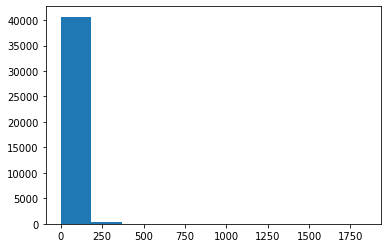

In [34]:
flat_stemmed_list = [item for sublist in total_stemmed_list for item in sublist]
flat_stemmed_len_list = [len(item) for sublist in total_stemmed_list for item in sublist]
print(flat_stemmed_len_list)

import matplotlib.pyplot as plt
plt.hist(flat_stemmed_len_list)

### Answer (d)

Create a bag of words representation

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
def bow_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = CountVectorizer(min_df=3, ngram_range=ngram_range,token_pattern=r'\b[^\d\W]+\b')
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


Build corpus arrays required for processing

In [36]:
print(len(total_stemmed_list))
flat_articles_corpus = []
flat_article_sentence_corpus = []
for article_list in total_stemmed_list:
  flat_article = ' '.join([' '.join(sentense) for sentense in article_list])
  flat_articles_corpus.append(flat_article)

  flat_sentence_list = [' '.join(sentense) for sentense in article_list]
  flat_article_sentence_corpus.append(flat_sentence_list)
print(len(flat_articles_corpus))

1725
1725


Validator function for different feature maps using k-means elbow method and sihouette score

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

def kmeans_validator(features_map,krange=range(2,10)):
  cluster_range = krange
  squared_distances = []
  silhouette_averages = []
  for num_clusters in cluster_range:
    # print(num_clusters)
    km = KMeans(n_clusters=num_clusters,
                  max_iter=10000)
    km.fit(features_map)
    squared_distances.append(km.inertia_)
    cluster_labels = km.fit_predict(features_map)
    # print(cluster_labels)
    silhouette_avg = silhouette_score(features_map, cluster_labels)
    silhouette_averages.append(silhouette_avg)
    print("For n_clusters =", num_clusters,
            "The average silhouette_score is :", silhouette_avg)


  plt.plot(cluster_range,squared_distances,'bx-')
  plt.xlabel("Cluster Range")
  plt.ylabel('Sum of Squared distances')
  plt.title('Elbow method plot for optimal cluster count')
  plt.show()

  plt.plot(cluster_range,silhouette_averages,'bx-')
  plt.xlabel("Cluster Range")
  plt.ylabel('Silhouette Averages')
  plt.title('Silhouette Average plot for optimal cluster count')
  plt.show()


from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print(df)

Bag of words representation

For n_clusters = 2 The average silhouette_score is : 0.9196608852653897
For n_clusters = 3 The average silhouette_score is : 0.38652556351721906
For n_clusters = 4 The average silhouette_score is : 0.36380436568851754
For n_clusters = 5 The average silhouette_score is : 0.22131252502090715
For n_clusters = 6 The average silhouette_score is : 0.21819284319811177
For n_clusters = 7 The average silhouette_score is : 0.2160857291978888
For n_clusters = 8 The average silhouette_score is : 0.21609015426445705
For n_clusters = 9 The average silhouette_score is : 0.18165424538353345


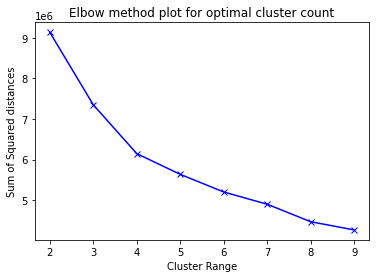

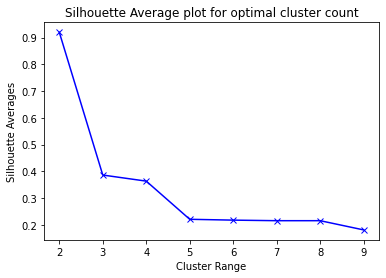

In [38]:
bow_vectorizer, bow_features = bow_extractor(flat_articles_corpus)
kmeans_validator(bow_features)

### Answer (e)

Get	a	better	‘signal’	for	identifying	more	crisp	clusters

Tfidf Representation

For n_clusters = 2 The average silhouette_score is : 0.006425753228075514
For n_clusters = 3 The average silhouette_score is : -0.005453792183698917
For n_clusters = 4 The average silhouette_score is : -0.002838893928932687
For n_clusters = 5 The average silhouette_score is : 0.0012596533124255172
For n_clusters = 6 The average silhouette_score is : 0.000148737387096734
For n_clusters = 7 The average silhouette_score is : -0.00047373335161546016
For n_clusters = 8 The average silhouette_score is : 0.0007120077235218046
For n_clusters = 9 The average silhouette_score is : 0.0031717794136333147


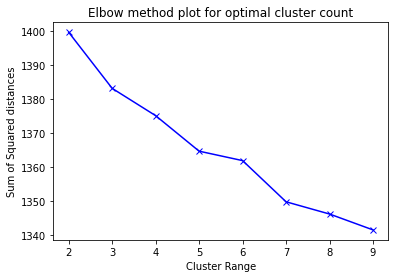

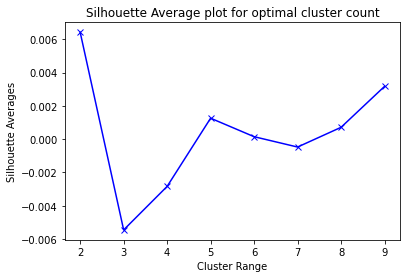

In [39]:
tfidf_vectorizer, tdidf_features = tfidf_extractor(flat_articles_corpus)
kmeans_validator(tdidf_features)

Bag of wards with bigram representation

For n_clusters = 2 The average silhouette_score is : 0.9249338626510628
For n_clusters = 3 The average silhouette_score is : 0.9024107271381472
For n_clusters = 4 The average silhouette_score is : 0.33510860797572445
For n_clusters = 5 The average silhouette_score is : 0.3414164862616286
For n_clusters = 6 The average silhouette_score is : 0.3353118428708684
For n_clusters = 7 The average silhouette_score is : 0.18787882499750733
For n_clusters = 8 The average silhouette_score is : 0.1922895443250573
For n_clusters = 9 The average silhouette_score is : 0.10685113170766249


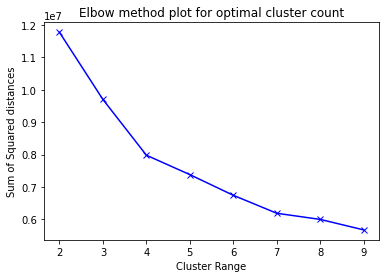

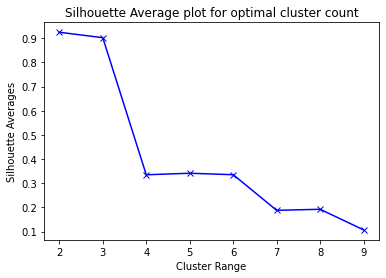

In [40]:
bow_vectorizer_2, bow_features_2 = bow_extractor(flat_articles_corpus,ngram_range=(1,2))
kmeans_validator(bow_features_2)

Tfidf with bigram representation

For n_clusters = 2 The average silhouette_score is : 6.243066047798823e-05
For n_clusters = 3 The average silhouette_score is : 0.001373485713975417
For n_clusters = 4 The average silhouette_score is : -0.0007152194707366223
For n_clusters = 5 The average silhouette_score is : -0.0017406300047340954
For n_clusters = 6 The average silhouette_score is : 0.000782168589088132
For n_clusters = 7 The average silhouette_score is : -0.0012659141186290518
For n_clusters = 8 The average silhouette_score is : 0.0016575064128233523
For n_clusters = 9 The average silhouette_score is : 0.002602287356953385


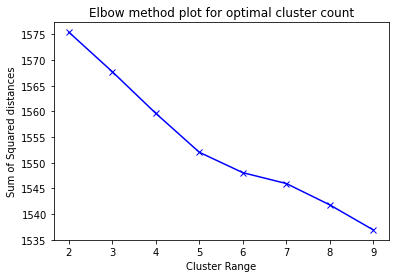

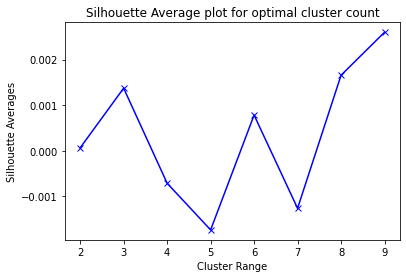

In [41]:
tfidf_vectorizer_2, tdidf_features_2 = tfidf_extractor(flat_articles_corpus,ngram_range=(1,2))
kmeans_validator(tdidf_features_2)

get low rank svd matrix using scipy.sparse.linalg's svds function 

In [42]:
from scipy.sparse.linalg import svds
    
def low_rank_svd(matrix, singular_count=1):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt


builds feature matrix with either count vectorizer or tfidf vectorizer

In [43]:
def build_feature_matrix(documents, feature_type='frequency'):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1, 
                                     ngram_range=(1, 1))
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=1, 
                                     ngram_range=(1, 1))
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1, 
                                     ngram_range=(1, 1))
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix



get sentense from the svd matrix

In [44]:
def get_low_rank_svd_sentense(dt_matrix,sentences):
  num_sentences = len(sentences)
  num_topics = 1
  
  td_matrix = dt_matrix.transpose()
  td_matrix = td_matrix.multiply(td_matrix > 0)
  u, s, vt = low_rank_svd(td_matrix,singular_count=num_topics) 

  sv_threshold = 0.5
  min_sigma_value = max(s) * sv_threshold
  s[s < min_sigma_value] = 0

  # Compute salience scores for all sentences in document
  salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
  # print(np.round(salience_scores, 2))

  # Rank sentences based on their salience scores
  top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1]
  top_sentence_indices.sort()

  # View the highest scoring sentence index positions
  # print(top_sentence_indices)

  top_sentences = []
  # # Get the document summary by combining the above sentences
  # # Compare the output with what gensim produces with its TextRank implementation
  for index in top_sentence_indices:
      top_sentences.append(sentences[index])

  return top_sentences

# kmeans_validator(svd_features)

calls above two function to get svd for the dataset
with bag of words vectorizer

displays the graphs for the generated matrix using kmeans validator function


For n_clusters = 2 The average silhouette_score is : 0.9196342254596798
For n_clusters = 3 The average silhouette_score is : 0.380928039817725
For n_clusters = 4 The average silhouette_score is : 0.3757891888021742
For n_clusters = 5 The average silhouette_score is : 0.21950655962565893
For n_clusters = 6 The average silhouette_score is : 0.22485097217029804
For n_clusters = 7 The average silhouette_score is : 0.23291204690118703
For n_clusters = 8 The average silhouette_score is : 0.12047387848780458
For n_clusters = 9 The average silhouette_score is : 0.1258980078073524


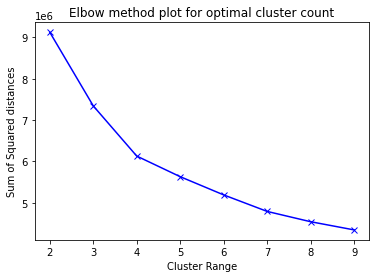

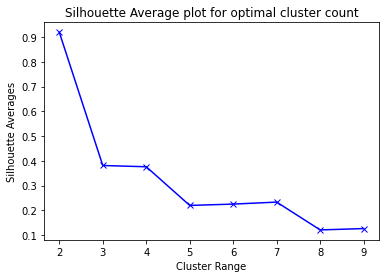

In [45]:
bow_svd_article_corpus = []
final_svd_flat_sentense_articles = []
errors = 0
for article in flat_article_sentence_corpus:
  try:
    vec, dt_matrix = build_feature_matrix(article, feature_type='frequency')
    svd_article = get_low_rank_svd_sentense(dt_matrix,article)
    bow_svd_article_corpus.append(' '.join(svd_article))
    final_svd_flat_sentense_articles.append(article)
  except:
    errors += 1
    


bow_vectorizer_svd, bow_features_svd = bow_extractor(bow_svd_article_corpus)
kmeans_validator(bow_features_svd)

calls above two function to get svd for the dataset with tfidf vectorizer

displays the graphs for the generated matrix using kmeans validator function

For n_clusters = 2 The average silhouette_score is : 0.009508826616903719
For n_clusters = 3 The average silhouette_score is : -0.00673291901458284
For n_clusters = 4 The average silhouette_score is : 0.0003178993682807394
For n_clusters = 5 The average silhouette_score is : 0.0010836134394455125
For n_clusters = 6 The average silhouette_score is : -0.0021545941807044984
For n_clusters = 7 The average silhouette_score is : -0.0061506724430918135
For n_clusters = 8 The average silhouette_score is : -0.004784172634510998
For n_clusters = 9 The average silhouette_score is : -0.00031694669916101605


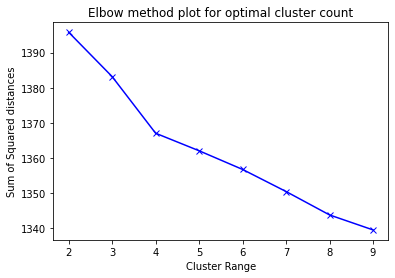

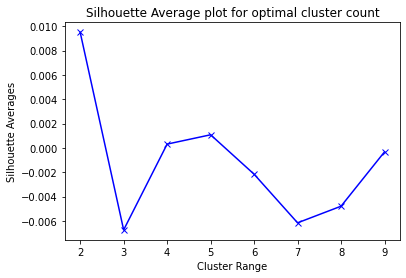

In [46]:
tfidf_svd_article_corpus = []

for article in flat_article_sentence_corpus:
  # print(article)
  try:
    vec, dt_matrix = build_feature_matrix(article, feature_type='tfidf')
    svd_article = get_low_rank_svd_sentense(dt_matrix,article)
    tfidf_svd_article_corpus.append(' '.join(svd_article))
  except:
    errors += 1
tfidf_vectorizer_svd, tdidf_features_svd = tfidf_extractor(tfidf_svd_article_corpus)
kmeans_validator(tdidf_features_svd)


Comprehensive results of the above outputs are as follows,

Evaluation technique | Elbow method | Silhouetter method
--- | --- | ---
BOW | 4 | 2 > 3 > 4
TFIDF | 3 | 2 > 6 > 8
BOW Bigram | 4 | 2 > 3 > 4
TFIDF Bigram | 3 | 2 > 9 > 8
BOW SVD | 4 | 2 > 3 > 4
TFIDF SVD | 4 | 2 > 8 > 3


Going through the above comparison table,
I assume the best number of clusters for the above data-set is 4



In [47]:
# write final dataset to csv
articledf = pd.DataFrame(tfidf_svd_article_corpus)
csv_data = articledf.to_csv('article_corpus.csv',index=False)

### Answer (f)

improve	the	categorization	of	news	articles	in order	to	create	a	predictive	model

for improved predictions, most promising things to do are,

*   Use a larger dataset
*   Use a pre-labeled dataset
*   improve the data cleaning
*   Use the labeled dataset to model a prediction with an algorithm that suits better.

Although, For this task i will create a labeled dataset using the previous classification parameters and try to build a prediction model with higher accuracy

In [48]:
import pandas as pd 

processed_data = 'https://github.com/damithdev/public_files/blob/master/article_corpus.csv?raw=true'

articledf = pd.read_csv(processed_data)

creating the labeled dataset with previously found best k value

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(min_df=1,ngram_range=(1, 1))
X = vectorizer.fit_transform(articledf['0'])

true_k = 4
model = KMeans(n_clusters=true_k,max_iter=10000)
model.fit(X)
clusters = model.labels_
articledf['cluster'] = clusters

csv_data = articledf.to_csv('article_labeled.csv',index=False)

* prediction evaluation metrics function

* model training function

In [50]:
from sklearn import metrics
import numpy as np

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    

def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)
    return classifier , predictions

Split the dataset into training and testing set



In [51]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(articledf, articledf.cluster, 
                                                        test_size=0.33, random_state=42)


The train the Multinominal naive bayes model and svm model using SGD Classifier. 

evaluate the model using test results

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier   

tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_X['0'])  
tfidf_test_features = tfidf_vectorizer.transform(test_X['0'])    

mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge')

print("Multinominal Naive Bayes classifier")
mnb_classifier, mnb_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_Y,
                                           test_features=tfidf_test_features,
                                           test_labels=test_Y)

print("Support vector machine classifier")
svm_classifier, svm_predictions = train_predict_evaluate_model(classifier=svm,
                                           train_features=tfidf_train_features,
                                           train_labels=train_Y,
                                           test_features=tfidf_test_features,
                                           test_labels=test_Y)

Multinominal Naive Bayes classifier
Accuracy: 0.69
Precision: 0.66
Recall: 0.69
F1 Score: 0.6
Support vector machine classifier
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the svm model using SGD classifier seems to perform better

* with a accuracy and precision of 0.94 this is far as a prediction model can get
* althout we would be able to improve this by using a larger dataset for the training.

save the model for future reuse

In [53]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(svm_classifier, open(filename, 'wb'))


predict the texts using created svm model

In [54]:
from urllib.request import urlopen

finalized_model_url = 'https://github.com/damithdev/public_files/blob/master/finalized_model.sav?raw=true'
loaded_model = pickle.load(urlopen(finalized_model_url))
result = loaded_model.score(tfidf_test_features, test_Y)
print(result)

def predict_text(text):
  tfidf_sample_features = tfidf_vectorizer.transform([text])
  prediction = svm_classifier.predict(tfidf_sample_features)
  print(prediction)

0.08626760563380281


In [55]:

predict_text(tfidf_svd_article_corpus[66])

[1]


### Answer (g)

fit a deep learning model that generalizes a predictive model
for news classification

For this task i will use a sequential deep learning model with LSTM layer and Dense layer with softmax activation

load the relevent dataset into a dataframe

In [56]:
import pandas as pd 

labeled_data = 'https://github.com/damithdev/public_files/blob/master/article_labeled.csv?raw=true'

df = pd.read_csv(labeled_data)
df.head()


,0,cluster
0,white hous chief of staff say stimulus negoti ...,1
1,xinjiang capit in wartim lockdown over spike i...,1
2,lindsay lohan denni quaid and other star from ...,2
3,for mani student who tri to take the act test ...,1
4,these are the state requir peopl to wear mask ...,1



*   Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector
*   Limit the data set to the top 5,0000 words
*   Set the max number of words in each article to 250.


In [57]:
from keras.preprocessing.text import Tokenizer


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each article.
MAX_SEQUENCE_LENGTH = 1000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['0'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 50320 unique tokens.


*  Truncate and pad the input sequences so that they are all in the same length for modeling.

In [58]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['0'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1721, 1000)


If the labels are in string format, Converting those labels to numbers.

In [59]:
Y = pd.get_dummies(df['cluster']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1721, 4)


train test split operation

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1548, 1000) (1548, 4)
(173, 1000) (173, 4)


Using Sequential Deep learning model for this task

* The first layer is the embedded layer that uses 100 length vectors to represent each word.
* SpatialDropout1D performs variational dropout in NLP models.
* The next layer is the LSTM layer with 100 memory units without dropout rate 0.2.
* The output layer must create 4 output values, one for each class according to the ground truth table of previous kmeans classification.
* Activation function is softmax for multi-class classification.
* Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [61]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1393 samples, validate on 155 samples
Epoch 1/5
1393/1393 [==============================] - 35s 25ms/step - loss: 1.2039 - accuracy: 0.6131 - val_loss: 1.0219 - val_accuracy: 0.6194
Epoch 2/5
1393/1393 [==============================] - 34s 25ms/step - loss: 0.9420 - accuracy: 0.6425 - val_loss: 0.8807 - val_accuracy: 0.6194
Epoch 3/5
1393/1393 [==============================] - 35s 25ms/step - loss: 0.9044 - accuracy: 0.6425 - val_loss: 0.8549 - val_accuracy: 0.6194
Epoch 4/5
1393/1393 [==============================] - 34s 25ms/step - loss: 0.7866 - accuracy: 0.6770 - val_loss: 0.8028 - val_accuracy: 0.6645
Epoch 5/5
1393/1393 [==============================] - 35s 25ms/step - loss: 0.6011 - accuracy: 0.7875 - val_loss: 0.7510 - val_accuracy: 0.7161


evaluate the model

In [62]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

173/173 [==============================] - 1s 6ms/step
Test set
  Loss: 0.763
  Accuracy: 0.699


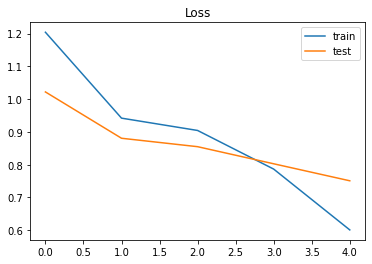

In [63]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

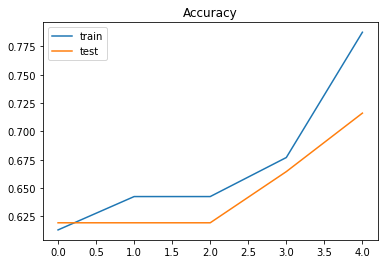

In [64]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [65]:
test_news = ['The investigational vaccine was developed by the biotechnology company Moderna and the National Institute of Allergy and Infectious Diseases, part of the National Institutes of Health. The trial is to be conducted at nearly 100 US research sites, according to Moderna. The first patient was dosed at a site in Savannah, Georgia.The trial is expected to enroll about 30,000 adult volunteers and evaluates the safety of the Moderna/NIH vaccine and whether it can prevent symptomatic Covid-19 after two doses, among other outcomes. Volunteers will receive either two 100 microgram injections of the vaccine or a placebo about 28 days apart. Investigators and participants will not know who has received the vaccine.Results from a Phase 1 trial of the vaccine published earlier this month in the New England Journal of Medicine found it induced immune responses in all of the volunteers and was generally safe. It had mild side effects, including fatigue, chills, headache, muscle pain, pain at the injection site.A Phase 1 study typically studies a small number of people and focuses on whether a vaccine is safe and elicits an immune response. In Phase 2, the clinical study is expanded and the vaccine is given to people who have characteristics -- such as age and physical health -- similar to those for whom the new vaccine is intended, according to the US Centers for Disease Control and Prevention. In Phase 3, the vaccine is given to thousands of people and tested for efficacy and again for safety.']
seq = tokenizer.texts_to_sequences(test_news)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

print(pred, "Predicted type : "+ str(np.argmax(pred)))

[[0.1467327  0.53344476 0.12459951 0.19522297]] Predicted type : 1


After using epoch 20 for training, the plots showed that the model has some overfitting issues. Possible solutions to fix this would be to reduce the number of epoch.

Reducing the epoch reduced the overfitting, but still a small overfitting is there which may be fixed by a larger and cleaner dataset.